## Problem 3 , Predicting image Labels Using Histogram of Gradients

The starter script is ‘main_problem3_NN.py’. The goal of this assignment is to build a feedforward neural network using the TENSORFLOW Library. We will use the histograms of oriented gradients (HoG) as image descriptors

+ Step 1: feature extraction. It uses the function get_hog_feature () to extract HoG features for both testing and training images. There are three parameters for HoG descriptors, i.e., number of orientation bins (9), cell size (8 by 8 pixels), and number of cells per block (2 by 2).
+ Step 2: Create a classifier using tensorflow. Please write your own codes in the placeholders to implement the FNN classifier. Note that we include the use of SVC codes to make the starter script complete. Please remove these coding lines before you work on your own codes.
+ Step 3: Retrieve failure images.

**Notes to the reader:**
+ I would try to use a different CNN structure that what is provided to solve the cifar_10 problem and see how the predictions are coming out to be
+ I used my own way to structure the tensor flow code to make it as clean as possible so that it is more concise and broken down into functions and readable, so this might be slightly different than what was done in the cifar_10.py file

In [1]:
import numpy as np
import scipy.io as sio
import sklearn.metrics as metrics
from skimage.feature import hog
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt

In [2]:
from fea_util import *

#################################################################################
###################### step 0:      loading data   ############################
#################################################################################
train_data, train_label, test_data, test_label = get_data()

#################################################################################
###################### step 1:      extract feature histograms   ################
#################################################################################

# set parameters for HOG 

orient = 9
pix_per_cell = 8
cell_per_block = 2

train_hog_feature, test_hog_feature = get_hog_feature(train_data, test_data, orient, pix_per_cell, cell_per_block)
train_hog_feature = np.array(train_hog_feature)
test_hog_feature = np.array(test_hog_feature)
train_hog_feature = train_hog_feature.reshape(len(train_label), -1)
test_hog_feature = test_hog_feature.reshape(len(test_hog_feature), -1)

print(train_hog_feature.shape)
print(test_hog_feature.shape)

C:\Users\asiaynrf\AppData\Local\Continuum\anaconda3\envs\tensorflowpy36\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
C:\Users\asiaynrf\AppData\Local\Continuum\anaconda3\envs\tensorflowpy36\lib\site-packages\skimage\feature\_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


(10262, 1764)
(1292, 1764)


### Understanding the original data
The original a batch data is (10262 x 64 x 64) dimensional tensor expressed in numpy array, where the number of columns, (10262), indicates the number of sample data. As stated in the dataset, the row vector, (1764) represents an hog of the image of 64x64 pixels. Since this project is going to use CNN for the classification tasks, the row vector, (1764), is not an appropriate form of image data to feed. In order to feed an image data into a CNN model, the dimension of the tensor representing an image data should be either (width x height x num_channel) or (num_channel x width x height). It depends on your choice (check out the tensorflow conv2d). In this particular project, I am going to use the dimension of the first choice because the default choice in tensorflow's CNN operation is so.

num_channel=1 for this case

[O] **need to be modified into a new shape**

#### Understanding the original labels
The label data is just a list of 10262 numbers in the range 1-68, which corresponds to each of the 68 classes

[X] **need to be modified into a new shape**

In [3]:
import pickle

def load_data_changed(train_x_feature, test_x_feature):
    train_features = train_x_feature.reshape((len(train_x_feature), 1, 42, 42)).transpose(0,2,3,1)
    test_features = test_x_feature.reshape((len(test_x_feature), 1, 42, 42)).transpose(0,2,3,1)
    return train_features, test_features


In [4]:
def display_stats(train_feature, test_feature):
    train_features,test_features= load_data_changed(train_feature, test_feature)
    return train_features, test_features

In [5]:
train_feature, test_feauture = display_stats(train_hog_feature, test_hog_feature)

In [6]:
# Print the shapes of all of the above 
print("Train set shape = {}, Test set shape = {}".format(train_feature.shape, test_feauture.shape))
print("Train labels shape = {}, Test labels shape = {}".format(len(train_label), len(test_label)))

Train set shape = (10262, 42, 42, 1), Test set shape = (1292, 42, 42, 1)
Train labels shape = 10262, Test labels shape = 1292


## Preprocessing

In [7]:
# normalize
def normalize(x):
    """
    x: input feature data or image data in numpy array [42, 42, 1]
    output: normalized x
    """
    min_val=np.min(x)
    max_val=np.max(x)
    x=(x-min_val)/(max_val-min_val)
    return x

#### One Hot Encode of the Labels
one_hot_encode function takes the input, x, which is a list of labels(ground truth). The total number of element in the list is the total number of samples in a batch. one_hot_encode function returns a 2 dimensional tensor, where the number of row is the size of the batch, and the number of column is the number of image classes.

In [8]:
# One hot encode
def one_hot_encoding(x):
    """
    x: A list of labels
    return one hot encoded matrix [10262, 68]
    """
    encoded = np.zeros((len(x), 68))
    for idx, value in enumerate(x):
        encoded[idx][value-1]=1
        
    return encoded

In [9]:
# Normalizing and one hot encoding the data
train_label = one_hot_encoding(train_label)
test_label = one_hot_encoding(test_label)

In [10]:
print(train_label.shape) # now the labels are one hot encoded

(10262, 68)


### Start the tensorflow part

In [11]:
import tensorflow as tf
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, shape=(None, 42, 42, 1), name='input_x')
y =  tf.placeholder(tf.float32, shape=(None, 68), name='output_y')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

In [12]:
def convnet(x, keep_prob):
    conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 1, 32],   mean=0, stddev=0.08))
    conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 32, 64],  mean=0, stddev=0.08))
    conv3_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
    
    # 1, 2
    conv1 = tf.nn.conv2d(x, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)
    
    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
    
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7
    flat = tf.contrib.layers.flatten(conv3_bn)
    
    # 8
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
     # 9
    out = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=68, activation_fn=None)
    return out

### Hyperparameters

In [13]:
epochs  =  10
batch_size  = 128
keep_probability = 0.7
learning_rate = 0.001

In [14]:
logits=convnet(x, keep_prob)
model=tf.identity(logits, 'logits') #Names Logits which can be loaded after training

#loss and optimizer
cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#Accuracy
correct_pred=tf.equal(tf.argmax(logits, 1), tf.arg_max(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
Use `argmax` instead


### Train the neural Network

In [15]:
def train_nn(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer,
                feed_dict={
                    x:feature_batch,
                    y:label_batch,
                    keep_prob:keep_probability
                }
    )

In [16]:
def show_stats(session, feature_batch, label_batch, cost, accuracy):
    loss=sess.run(cost,
                  feed_dict={
                      x: feature_batch,
                      y:label_batch,
                      keep_prob:1
                  })
    valid_acc=sess.run(accuracy,
                      feed_dict={
                          x:feature_batch,
                          y:label_batch,
                          keep_prob:1
                      })
    print('Loss: {:>10.4f}, Training set accuracy: {:.6f}'.format(loss, valid_acc))

In [17]:
def gen_batch(data, batch_size, num_iter):
    data =  np.array(data)
    index = len(data)
    for i in range(num_iter):
        index += batch_size
        if (index + batch_size > len(data)):
            index = 0
            shuffled_indices = np.random.permutation(np.arange(len(data)))
            data = data[shuffled_indices]
        yield data[index:index + batch_size]

In [18]:
from datetime import datetime
train_dir='tf_logs'
logdir = train_dir + '/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'

# Operation merging summary data for TensorBoard
summary = tf.summary.merge_all()

# Define saver to save model state at checkpoints
saver = tf.train.Saver()

In [19]:
# Train
import os
max_steps=2000
save_model_pathsave_mod  = './image_classification'
print(".... Training the model")
with tf.Session() as sess:
    #Initializing the variables
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter(logdir, sess.graph)

    #Generate input data batches
    zipped_data = zip(train_feature, train_label)
    batches=gen_batch(list(zipped_data), batch_size,max_steps)
    
    for i in range(max_steps):
        batch = next(batches)
        batch_features, batch_labels = zip(*batch)
        
        train_nn(sess, optimizer, keep_probability, batch_features, batch_labels)
        
        # Periodically print out the model's current accuracy
        if i % 100 == 0: show_stats(sess, batch_features, batch_labels, cost, accuracy)
        
        # Periodically save checkpoint
        if (i + 1) % 1000 == 0:
            checkpoint_file = os.path.join(train_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=i)
            print('Saved checkpoint')
     # After finishing the training, evaluate on the test set
    test_accuracy = sess.run(accuracy, feed_dict={
    x: test_feauture,
    y: test_label,
    keep_prob:1})
    print('Test accuracy {:g}'.format(test_accuracy))
    #Save Model
    save_path=saver.save(sess, save_model_pathsave_mod)

.... Training the model
Loss:     4.1989, Training set accuracy: 0.039062
Loss:     2.9408, Training set accuracy: 0.335938
Loss:     1.0194, Training set accuracy: 0.804688
Loss:     0.3395, Training set accuracy: 0.945312
Loss:     0.0737, Training set accuracy: 0.992188
Loss:     0.0460, Training set accuracy: 1.000000
Loss:     0.0139, Training set accuracy: 1.000000
Loss:     0.0087, Training set accuracy: 1.000000
Loss:     0.0036, Training set accuracy: 1.000000
Loss:     0.0028, Training set accuracy: 1.000000
Saved checkpoint
Loss:     0.0008, Training set accuracy: 1.000000
Loss:     0.0046, Training set accuracy: 1.000000
Loss:     0.0006, Training set accuracy: 1.000000
Loss:     0.0005, Training set accuracy: 1.000000
Loss:     0.0002, Training set accuracy: 1.000000
Loss:     0.0006, Training set accuracy: 1.000000
Loss:     0.0001, Training set accuracy: 1.000000
Loss:     0.0007, Training set accuracy: 1.000000
Loss:     0.0004, Training set accuracy: 1.000000
Loss:    

### Accuracy of this model
+ The accuracy is found to be 97.4% which is very high as this model performs the best of all the Models we tried as of now

In [34]:
'''
def batch_features_labels(features, labels, batch_size):
    for start in range(0, len(features), batch_size):
        end=min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

def display_image_predictions(features, labels, predictions):
    n_classes=68
    label_names=[i for i in range(n_classes)]
    #label_binarizer=LabelBinarizer()
    #label_binarizer.fit(range(n_classes))
    label_ids = np.array(label_names)
    
    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)
    
    n_predictions=3
    margin=0.05
    ind=np.arange(n_predictions)
    width=(1. - 2. * margin) / n_predictions
    
    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])
'''

In [35]:
test_feauture.shape

(1292, 42, 42, 1)

In [45]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import random

save_model_path = './image_classification'
batch_size=64
n_samples=10
top_n_predictions=5


print(".... Testing the model")
loaded_graph=tf.Graph()

with tf.Session(graph=loaded_graph) as sess:
    #Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    #load the meodel
    loader=tf.train.import_meta_graph(save_model_pathsave_mod+'.meta')
    loader.restore(sess, save_model_path)
    
    #Get tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
    loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
    
    test_batch_acc_total=0
    test_batch_count=0
    #print(test_feauture.shape)
    test_features=test_feauture
    test_labels=test_label
    idx = [i for i in range(1292)]
    for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    # Print Random Samples
    random_index, random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(idx, test_features, test_labels)), n_samples)))
    random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
    #Save Model
    print(random_index)
    print(random_test_predictions)
    #display_image_predictions(random_test_features, random_test_labels, random_test_predictions)
    save_path=saver.save(sess, save_model_pathsave_mod)

.... Testing the model
INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.9714781755492801

(104, 407, 936, 689, 597, 212, 820, 25, 1087, 352)
TopKV2(values=array([[9.99716461e-01, 1.48572813e-04, 1.01044010e-04, 1.48211875e-05,
        1.17217523e-05],
       [9.99986887e-01, 9.01786279e-06, 2.60623028e-06, 1.30241142e-06,
        7.63437740e-08],
       [1.00000000e+00, 1.01842845e-08, 7.48032924e-09, 1.45024692e-09,
        2.49626014e-10],
       [9.99999642e-01, 2.25863801e-07, 5.67856979e-08, 5.07350748e-08,
        4.60010234e-08],
       [9.99997258e-01, 1.31818967e-06, 7.85903637e-07, 5.79075788e-07,
        5.35247864e-08],
       [9.99999642e-01, 1.40675752e-07, 1.00327632e-07, 2.52288945e-08,
        1.41237324e-08],
       [9.99993682e-01, 6.14949658e-06, 1.69190599e-07, 6.43524700e-09,
        6.05899997e-09],
       [9.99997973e-01, 1.01018395e-06, 7.65244181e-07, 3.18205167e-07,
        2.82393522e-08],
       [9.99949098e-01, 3.0162558

In [46]:
random_test_labels

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

### Results below and Predicted pictures 
+ Lets look at the above random test labels and the softmax values that are predicted for the indices
+ Case1 for the random predictions
    - predicted values = [**9.99716461e-01**, 1.48572813e-04, 1.01044010e-04, 1.48211875e-05,1.17217523e-05]
    - indices = [20, 24, 39, 25,  8]
    - we see the 1st index is highest value predicted ie, 1, so the label that is predicted for the picture is at index =20
    - Looking at the test label
    - We see the index to be **20** as below 
    
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]
+ **As we can see the misprediction/misclassification is pretty low for this case and is dificult to catch**
    

Test label for the below test image = 20


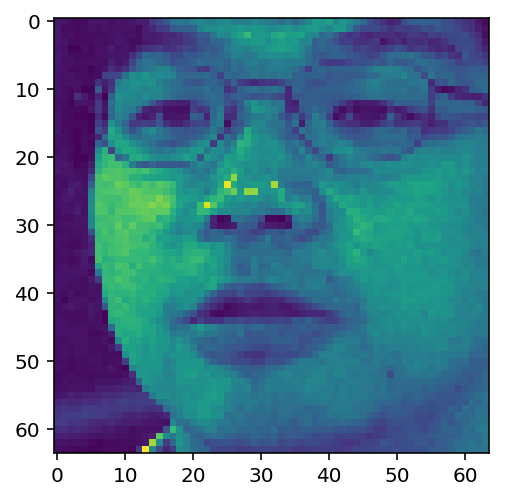

In [53]:
plt.imshow(test_data[104])
print("Test label for the below test image = {}".format(list(test_label[104]).index(1)))